<a href="https://colab.research.google.com/github/wjosefw/Signal-processing-with-Neural-networks/blob/main/Codigos_Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##IMPORTADO DE MÓDULOS

In [ ]:
import numpy as np
import numpy.matlib

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk
  
import tensorflow as tf
tf.version.VERSION

'2.9.2'

In [ ]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

## Ejemplo de evento
 * Datos Con Splines - 0.2ns step size
 * 600 pasos temporales
 * 2 Canales (uno por detector)
 * Eliminada la linea de base

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
!tar -xzvf '/content/gdrive/MyDrive/data/fuentes_Alba.tgz'  -C /content

co60_10k_2cm_8cm.dat
co60_10k_5cm_5cm.dat
co60_10k_8cm_2cm.dat
na22_10k_2cm_8cm.dat
na22_10k_5cm_5cm.dat
na22_10k_8cm_2cm.dat


In [ ]:
#fichero = np.fromfile('/content/co60_10k_5cm_5cm.dat', dtype='float32')
fichero = np.fromfile('/content/na22_10k_2cm_8cm.dat', dtype='float32')
print(fichero.shape)

(26000000,)


In [ ]:
Nt2 = 600
Nev = 10000
Nc = 2
limit=Nev*Nt2*Nc
V=fichero[0:limit].reshape((Nev,Nt2,Nc))
print(V.shape)

(10000, 600, 2)


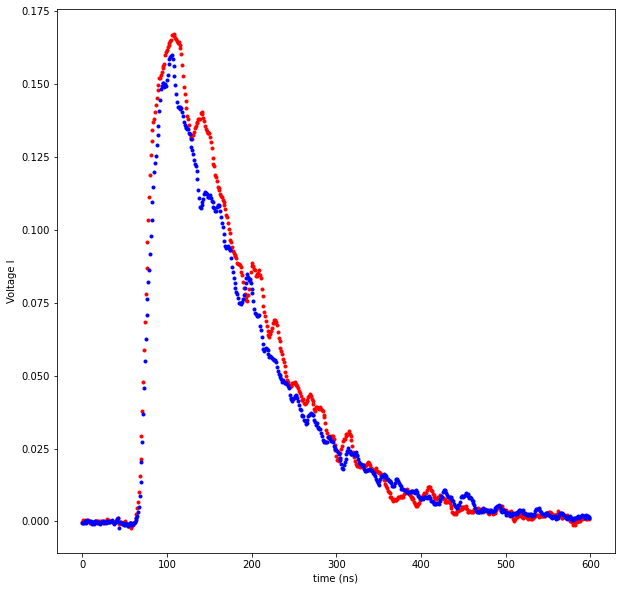

In [ ]:
plt.figure(figsize=(10,10))
plt.xlabel('time (ns)')
plt.ylabel('Voltage I')
plt.plot(V[0,:,0],'.r')
plt.plot(V[0,:,1],'b.')

## Espectros 

### ESPECTRO DE ENERGÍA BASADO EN EL ÁREA

In [ ]:
threshold = 0.025
print(V.shape)
for i in range(Nev):
  index1=np.where(V[i,:,0]<threshold)[0]
  index2=np.where(V[i,:,1]<threshold)[0]
  V[i,index1,0]=0
  V[i,index2,1]=0
DT=0.2
SUM=np.sum(V*0.2,axis=1)

(10000, 600, 2)


In [ ]:
#Para el primer detector
histogE, binsE = np.histogram(SUM[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m=511/((binsE[index+1]+binsE[index])/2)
calibrado1=m*SUM[:,0]


El centro está en el bin con bordes([500.] , [510.])


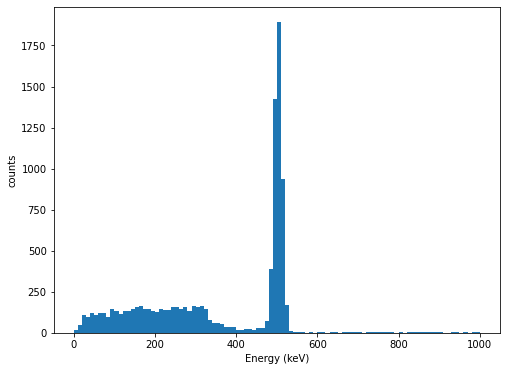

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Energy (keV)')
plt.ylabel('counts')
histogE, binsE, patchesE  = plt.hist(calibrado1,bins=100,range=[0,1000])
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
print('El centro está en el bin con bordes(' + str(binsE[index]) + ' , '  + str(binsE[index+1]) + ')')

In [ ]:
#para el segundo detector
histogE, binsE = np.histogram(SUM[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m=511/((binsE[index+1]+binsE[index])/2)
calibrado2=m*SUM[:,1]


El centro está en el bin con bordes([510.] , [520.])


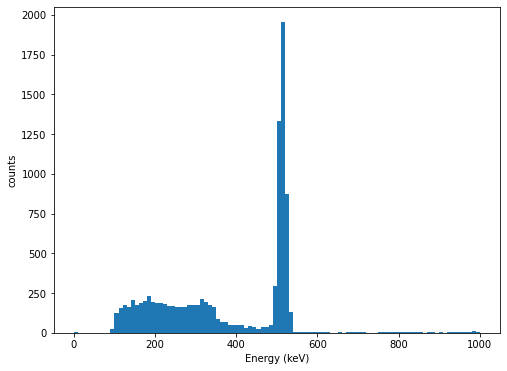

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Energy (keV)')
plt.ylabel('counts')
histogE, binsE, patchesE  = plt.hist(calibrado2,bins=100,range=[0,1000])
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
print('El centro está en el bin con bordes(' + str(binsE[index]) + ' , '  + str(binsE[index+1]) + ')')

### ESPECTRO DE ENERGIA BASADO EN EL MAXIMO

In [ ]:
# CALCULAMOS EL MAXIMO DE CADA PULSO
MAX = np.max(V,axis=1,keepdims=True)
print(MAX.shape)
MAX2 = np.tile(MAX,(1,Nt2,1)) 
VN = V/MAX2  # NORMALIZAMOS POR EL AREA O POR EL MAXIMO

(10000, 1, 2)


[480.]


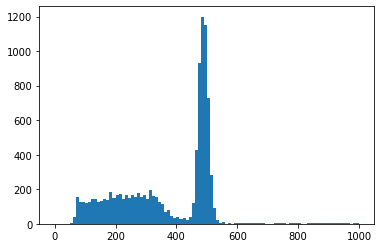

In [ ]:
cal0 = 2200  # To obtain calibration in Energy (keV)
histogE, binsE, patchesE  = plt.hist(cal0*MAX[:,:,0],bins=100,range=[0,1000]);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
print(binsE[index])

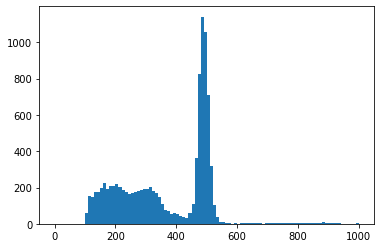

In [ ]:
cal1 = 3200  # To obtain calibration in Energy (keV)
histogE, binsE, patchesE  = plt.hist(cal1*MAX[:,0,1],bins=100,range=[0,1000]);

# Neural network

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.losses import mse
import keras.backend as K

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#!tar -xzvf '/content/gdrive/MyDrive/data/fuentes_Alba.tgz'  -C /content
!tar -xzvf '/content/gdrive/MyDrive/data/fuentes_50k_Alba.tgz' -C /content

co-2cm-8cm.dat
co-5cm-5cm.dat
co-8cm-2cm.dat
na-2cm-8cm.dat
na-5cm-5cm.dat
na-8cm-2cm.dat


In [7]:
fichero1 = np.fromfile('/content/na-2cm-8cm.dat', dtype='float32')
fichero2 = np.fromfile('/content/na-5cm-5cm.dat', dtype='float32')
fichero3 = np.fromfile('/content/na-8cm-2cm.dat', dtype='float32')
#fichero2 = np.fromfile('/content/na22_10k_8cm_2cm.dat', dtype='float32')
#fichero3 = np.fromfile('/content/na22_10k_2cm_8cm.dat', dtype='float32')

#fichero4 = np.fromfile('/content/co60_10k_5cm_5cm.dat', dtype='float32')
#fichero5 = np.fromfile('/content/co60_10k_8cm_2cm.dat', dtype='float32')
#fichero6 = np.fromfile('/content/co60_10k_2cm_8cm.dat', dtype='float32')

Nt2 = 600
Nev = 50000
Nc = 2

V1 = fichero1[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))
V2 = fichero2[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))
V3 = fichero3[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))
#V4 = fichero4[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))
#V5 = fichero5[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))
#V6 = fichero6[0:Nt2*Nev*Nc].reshape((Nev,Nt2,Nc))

## Single position

### Method 1: standarization

In [ ]:
VN1=(V1-np.mean(V1))/np.std(V1)
VN2=(V2-np.mean(V2))/np.std(V2)
VN3=(V3-np.mean(V3))/np.std(V3)
#VN4=(V4-np.mean(V4))/np.std(V4)
#VN5=(V5-np.mean(V5))/np.std(V5)
#VN6=(V6-np.mean(V6))/np.std(V6)

### Method 2: Logarithmic

-0.44183362
-0.31350017


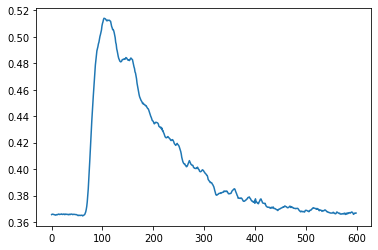

In [ ]:
min1=np.min(V2[:,:,0])
print(min1)
V2[:,:,0]=(np.log((V2[:,:,0])-min1+1))



min2=np.min(V2[:,:,1])
print(min2)
V2[:,:,1]=(np.log((V2[:,:,1])-min2+1))

VN1 = V2 #Fuente na22 centrada
plt.plot(VN1[1,:,0])

### Method 3: Area

In [ ]:
SUM1=np.sum(V1*0.2,axis=1)
print(SUM1.shape)

#Para el primer detector
histogE, binsE = np.histogram(SUM1[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m11=511/((binsE[index+1]+binsE[index])/2)
calibrado11=m11*SUM1[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM1[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m21=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m21*SUM1[:,0]

SUM2=np.sum(V2*0.2,axis=1)
print(SUM2.shape)

#Para el primer detector
histogE, binsE = np.histogram(SUM2[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m12=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m12*SUM2[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM2[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m22=511/((binsE[index+1]+binsE[index])/2)
calibrado22=m22*SUM2[:,0]


SUM3=np.sum(V3*0.2,axis=1)
print(SUM3.shape)

#Para el primer detector
histogE, binsE = np.histogram(SUM3[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m13=511/((binsE[index+1]+binsE[index])/2)
calibrado31=m13*SUM3[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM3[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m23=511/((binsE[index+1]+binsE[index])/2)
#calibrado33=m23*SUM3[:,0]


V1 = V1[(m11*SUM1[:,0]>480) & (m11*SUM1[:,0]<540) & (m21*SUM1[:,1]>480) & (m21*SUM1[:,1]<540),:,:]
V2 = V2[(m12*SUM2[:,0]>480) & (m12*SUM2[:,0]<540) & (m22*SUM2[:,1]>480) & (m22*SUM2[:,1]<540),:,:]
V3 = V3[(m13*SUM3[:,0]>480) & (m13*SUM3[:,0]<540) & (m23*SUM3[:,1]>480) & (m23*SUM3[:,1]<540),:,:]

VN1=(V1-np.mean(V1))/np.std(V1)
VN2=(V2-np.mean(V1))/np.std(V1)
VN3=(V3-np.mean(V1))/np.std(V1)


print(VN1.shape,VN2.shape,VN3.shape,np.mean(VN2),np.mean(V3))


(50000, 2)
(50000, 2)
(50000, 2)
(11411, 600, 2) (12648, 600, 2) (10571, 600, 2) 0.024899371 0.044767324


In [ ]:
SUM1=np.sum(V1*0.2,axis=1)
print(np.mean(SUM1[:,0]),np.mean(SUM1[:,1]))

#Para el primer detector
histogE, binsE = np.histogram(SUM1[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m11=511/((binsE[index+1]+binsE[index])/2)
calibrado11=m11*SUM1[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM1[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m21=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m21*SUM1[:,0]

SUM2=np.sum(V2*0.2,axis=1)
print(np.mean(SUM2[:,0]),np.mean(SUM2[:,1]))

#Para el primer detector
histogE, binsE = np.histogram(SUM2[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m12=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m12*SUM2[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM2[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m22=511/((binsE[index+1]+binsE[index])/2)
calibrado22=m22*SUM2[:,0]


SUM3=np.sum(V3*0.2,axis=1)
print(np.mean(SUM3[:,0]),np.mean(SUM3[:,1]))


#Para el primer detector
histogE, binsE = np.histogram(SUM3[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m13=511/((binsE[index+1]+binsE[index])/2)
calibrado31=m13*SUM3[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM3[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m23=511/((binsE[index+1]+binsE[index])/2)
#calibrado33=m23*SUM3[:,0]

V1 = V1[(m11*SUM1[:,0]>470) & (m11*SUM1[:,0]<550) & (m21*SUM1[:,1]>470) & (m21*SUM1[:,1]<550),:,:]
V2 = V2[(m12*SUM2[:,0]>470) & (m12*SUM2[:,0]<550) & (m22*SUM2[:,1]>470) & (m22*SUM2[:,1]<550),:,:]
V3 = V3[(m13*SUM3[:,0]>470) & (m13*SUM3[:,0]<550) & (m23*SUM3[:,1]>470) & (m23*SUM3[:,1]<550),:,:]


mean_0=np.mean([np.mean(V1[:,:,0]),np.mean(V2[:,:,0]),np.mean(V3[:,:,0])])
mean_1=np.mean([np.mean(V1[:,:,1]),np.mean(V2[:,:,1]),np.mean(V3[:,:,1])])
desv_est_0=np.mean([np.std(V1[:,:,0]),np.std(V2[:,:,0]),np.std(V3[:,:,0])])
desv_est_1=np.mean([np.std(V1[:,:,1]),np.std(V2[:,:,1]),np.std(V3[:,:,1])])

V1[:,:,0]=(V1[:,:,0]-mean_0)/desv_est_0
V1[:,:,1]=(V1[:,:,1]-mean_1)/desv_est_1
V2[:,:,0]=(V2[:,:,0]-mean_0)/desv_est_0
V2[:,:,1]=(V2[:,:,1]-mean_1)/desv_est_1
V3[:,:,0]=(V3[:,:,0]-mean_0)/desv_est_0
V3[:,:,1]=(V3[:,:,1]-mean_1)/desv_est_1


print(V1.shape,V2.shape,V3.shape)

4.8790483 3.2595406
4.8404737 3.5354571
4.4527645 3.5460122
(11744, 600, 2) (12988, 600, 2) (11832, 600, 2)


In [ ]:
print(np.std(V1[:,:,0]),np.std(V2[:,:,0]),np.std(V3[:,:,0]))

0.99399805 1.0169921 0.9890111


In [ ]:
INPUT=V3[:,60:124,:]
Ncasos=INPUT.shape[0]

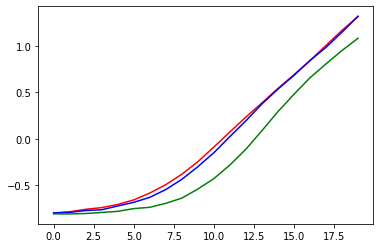

In [ ]:
plt.plot(V1[0,60:80,0],'r-')
plt.plot(V2[0,60:80,0],'b-')
plt.plot(V3[0,60:80,0],'g-')

### Method 4: Maximum

In [ ]:
# CALCULAMOS EL MAXIMO DE CADA PULSO na22

MAX1 = np.max(V1,axis=1,keepdims=True)
M1 = np.mean(MAX1) 
VN1 = V1/M1  # DIVIDIMOS POR LA MEDIA DEL MÁXIMO DE CADA PULSO
print(VN1)


MAX2 = np.max(V2,axis=1,keepdims=True)
M2 = np.mean(MAX2) 
VN2 = V2/M2 


MAX3 = np.max(V3,axis=1,keepdims=True)
M3 = np.mean(MAX3) 
VN3 = V3/M3  

# CALCULAMOS EL MAXIMO DE CADA PULSO co60

MAX4 = np.max(V4,axis=1,keepdims=True)
M4 = np.mean(MAX4) 
VN4 = V4/M4  

MAX5 = np.max(V5,axis=1,keepdims=True)
M5 = np.mean(MAX5) 
VN5 = V5/M5  

MAX6 = np.max(V6,axis=1,keepdims=True)
M6 = np.mean(MAX6) 
VN6 = V6/M6  #

[[[ 2.09431304e-03  6.10517431e-03]
  [-3.39781097e-03  1.47108315e-03]
  [-4.58606100e-03  2.63988436e-03]
  ...
  [ 1.11505091e-02  4.47474886e-03]
  [ 9.90956370e-03  4.57734847e-03]
  [ 6.27151225e-03  4.99236304e-03]]

 [[-1.34836114e-03 -2.43640854e-03]
  [-3.50845000e-03 -1.50079920e-03]
  [-2.16980069e-03 -1.85298326e-03]
  ...
  [ 2.01115813e-02  2.73804879e-04]
  [ 2.16770414e-02 -6.39879261e-04]
  [ 2.18706727e-02  1.76628469e-03]]

 [[-3.17623280e-03 -2.55893613e-03]
  [-2.09819805e-03 -2.72505288e-03]
  [ 4.87981997e-05 -7.87892262e-04]
  ...
  [ 1.27407378e-02  2.53989752e-02]
  [ 1.33375246e-02  2.22649965e-02]
  [ 1.41018769e-02  2.49882005e-02]]

 ...

 [[-4.08920256e-04 -1.16185553e-03]
  [ 3.52475583e-03  2.64673214e-03]
  [ 4.90036386e-04 -9.15616285e-04]
  ...
  [ 7.55682681e-03  1.40985446e-02]
  [ 6.62294216e-03  1.14895748e-02]
  [ 8.30507185e-03  1.19380327e-02]]

 [[ 8.05163756e-04 -5.08151366e-04]
  [ 2.84005259e-03  2.16108121e-04]
  [-1.06253021e-04  1.7497

### Data filtering

In [ ]:
cal0 = 2200 
cal1 = 3200 
#Filtramos los eventos con la energía adecuada para cada fuente

#VNN1 = VN1[(cal0*MAX1[:,0,0]>450) & (cal0*MAX1[:,0,0]<550) & (cal1*MAX1[:,0,1]>550) & (cal1*MAX1[:,0,1]<650),:,:]
#VNN2 = VN2[(cal0*MAX1[:,0,0]>450) & (cal0*MAX1[:,0,0]<550) & (cal1*MAX1[:,0,1]>550) & (cal1*MAX1[:,0,1]<650),:,:]
#VNN3 = VN3[(cal0*MAX1[:,0,0]>450) & (cal0*MAX1[:,0,0]<550) & (cal1*MAX1[:,0,1]>550) & (cal1*MAX1[:,0,1]<650),:,:]

#VNN1 = V1[(m1*SUM[:,0]>450) & (m1*SUM[:,0]<550) & (m2*SUM[:,1]>550) & (m2*SUM[:,1]<650),:,:]
#VNN2 = V2[(m1*SUM[:,0]>450) & (m1*SUM[:,0]<550) & (m2*SUM[:,1]>550) & (m2*SUM[:,1]<650),:,:]
#VNN3 = V3[(m1*SUM[:,0]>450) & (m1*SUM[:,0]<550) & (m2*SUM[:,1]>550) & (m2*SUM[:,1]<650),:,:]
VNN1 = VN1[:,:,:]
VNN2 = VN2[:,:,:]
VNN3 = VN2[:,:,:]


NameError: ignored

In [ ]:
Nev1 = [VNN1.shape[0],VNN3.shape[0],VNN3.shape[0]]
Ncasos = np.min(Nev1)  #Numero de eventos tras filtrar en energia AMBOS
remainder=(Ncasos % 256)
Ncasos=Ncasos-remainder
print(Ncasos,Ncasos/256)
Na_complete = np.concatenate((VNN1[0:Ncasos,40:104,:],VNN2[0:Ncasos,40:104,:],VNN3[0:Ncasos,40:104,:]), axis=0, out=None)

Npositions = 3
print(np.shape(Na_complete))
INPUT = Na_complete

3584 14.0
(10752, 64, 2)


In [ ]:
Ncasos=VNN3.shape[0]
print(VNN3.shape[0])
INPUT = VNN3 

12648


### Interpolation and offset

In [ ]:
from scipy.interpolate import interp1d
tiempo1 = np.linspace(0, 64, 64)  # 64 time points (initially) 0.2ns step
f_out = interp1d(tiempo1, INPUT, axis=1)
INPUT_64 = f_out(tiempo1)
#tiempo2 = np.linspace(0, 64, 128) # interpolated into 128 time points  0.1ns step
#INPUT_128 = f_out(tiempo2)

#print(tf.shape(INPUT_128))
print(tf.shape(INPUT_64))

NameError: ignored

In [ ]:
INPUT2 = np.zeros_like(INPUT)
REF = np.zeros((Ncasos,),dtype=np.float32)

tstep = 0.2
NRD0 = 1+np.random.randint(9, size=Ncasos)  
NRD1 = 1+np.random.randint(9, size=Ncasos)

offsets_position=[1.0029,0,-1.0029]
#for j in range(Npositions):   
offsetT = offsets_position[2]  

for i in range(Ncasos):
  N0 = NRD0[i] 
  INPUT2[i,:,0]=np.roll(INPUT[i,:,0],N0)
  INPUT2[i,0:N0,0] = INPUT[i,0:N0,0]
  N1 = NRD1[i]
  INPUT2[i,:,1]=np.roll(INPUT[i,:,1],N1)
  INPUT2[i,0:N1,1] = INPUT[i,0:N1,1]
  REF[i]=(N1-N0-offsetT)  #ns
  #REF[i]=N1-N0  #time steps


### Model and input tensor construction

In [ ]:
Ntrain = np.floor(0.7*Ncasos).astype(int)   #check if power of 2 needed

trainX = INPUT2[0:Ntrain,:,:]
testX = INPUT2[Ntrain:Ncasos,:,:]

REF_train = REF[0:Ntrain]
REF_test = REF[Ntrain:Ncasos]

In [ ]:
# define two sets of inputs
# https://stackoverflow.com/questions/49875127/share-weights-between-two-dense-layers-in-keras
# https://stackoverflow.com/questions/66934276/how-to-create-a-model-with-multiple-shared-layers-in-keras-functional-api
offset_inicial = 0.0
inputA = Input(shape=(64,),)
inputB = Input(shape=(64,))
input_REF = Input(shape=(1,))

x1 = Dense(256, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.05))
x2 = Dense(64, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.05))
x3 = Dense(1, activation="relu")

#kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.5)

op1A = x1(inputA)
op2A = x2(op1A)
op3A = x3(op2A)

op1B = x1(inputB)
op2B = x2(op1B)
op3B = x3(op2B)

model_na_5_5 = Model(inputs=[inputA, inputB, input_REF], outputs=[op3A,op3B])

# OPTION 1 - USING LOSS FUNCTION IN THE MODEL
# https://stackoverflow.com/questions/51680818/keras-custom-loss-as-a-function-of-multiple-outputs
# Construct your custom loss as a tensor And Compile without specifying a loss
#loss = K.std(op3B-op3A-input_REF-offset_inicial) 
loss = 0.3*K.mean(abs(op3B-op3A-input_REF))+0.7*K.std(op3B-op3A-input_REF) 
## Add loss to model
model_na_5_5.add_loss(loss)

model_na_5_5.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_65 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 dense_63 (Dense)               (None, 256)          16640       ['input_64[0][0]',               
                                                                  'input_65[0][0]']               
                                                                                                  
 dense_64 (Dense)               (None, 64)           16448       ['dense_63[0][0]',        

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_na_5_5.compile(optimizer=opt) #, metrics=['accuracy']
history = model_na_5_5.fit(x=[trainX[:,:,0], trainX[:,:,1], REF_train],y=None,validation_data=([testX[:,:,0], testX[:,:,1],REF_test],[]),epochs=350, batch_size=128,shuffle=True)  

Epoch 1/350
65/65 [==============================] - 1s 9ms/step - loss: 3.0986 - val_loss: 2.5747
Epoch 2/350
65/65 [==============================] - 0s 8ms/step - loss: 1.8891 - val_loss: 1.2145
Epoch 3/350
65/65 [==============================] - 1s 8ms/step - loss: 1.0563 - val_loss: 0.9916
Epoch 4/350
65/65 [==============================] - 0s 7ms/step - loss: 0.9955 - val_loss: 0.9637
Epoch 5/350
65/65 [==============================] - 0s 7ms/step - loss: 0.9675 - val_loss: 0.9457
Epoch 6/350
65/65 [==============================] - 1s 9ms/step - loss: 0.9507 - val_loss: 0.9307
Epoch 7/350
65/65 [==============================] - 0s 7ms/step - loss: 0.9347 - val_loss: 0.9204
Epoch 8/350
65/65 [==============================] - 0s 7ms/step - loss: 0.9255 - val_loss: 0.9134
Epoch 9/350
65/65 [==============================] - 0s 6ms/step - loss: 0.9148 - val_loss: 0.9090
Epoch 10/350
65/65 [==============================] - 0s 7ms/step - loss: 0.9070 - val_loss: 0.8969
Epoch 11/

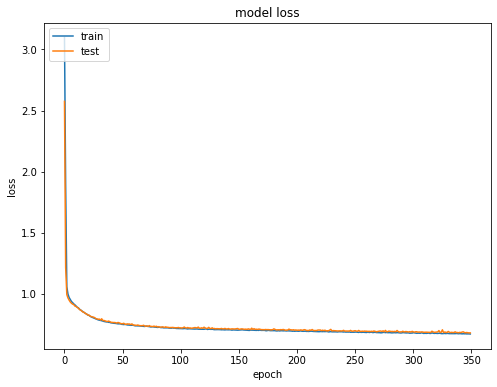

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction and Gaussian/Lorentzian fit

In [ ]:
INPUT_test = V1[:,60:124,:] #Fuente na22 centrada
#tiempo_test = np.linspace(0, 64, 64)  # 64 time points (initially) 0.2ns step
#f_out = interp1d(tiempo_test, INPUT_test, axis=1)
#INPUT_64_test = f_out(tiempo_test)
Ncasos_test=INPUT_test.shape[0]
print(tf.shape(INPUT_test))

tf.Tensor([11744    64     2], shape=(3,), dtype=int32)


In [ ]:
INPUT2_test = np.zeros_like(INPUT_test)
REF_test_1 = np.zeros((Ncasos_test,),dtype=np.float32)

tstep = 0.2
NRD0 = 1+np.random.randint(9, size=Ncasos_test)  # +-10 steps of 0.1ns of offset --> 1ns = 30cm --> EQUIVALENT TO MOVING THE SOURCE +-30cm
NRD1 = 1+np.random.randint(9, size=Ncasos_test)

for i in range(Ncasos_test):
  N0 = NRD0[i]
  INPUT2_test[i,:,0]=np.roll(INPUT_test[i,:,0],N0)
  INPUT2_test[i,0:N0,0] = INPUT_test[i,0:N0,0]
  N1 = NRD1[i]
  INPUT2_test[i,:,1]=np.roll(INPUT_test[i,:,1],N1)
  INPUT2_test[i,0:N1,1] = INPUT_test[i,0:N1,1]
  #REF_test_1[i]=tstep*(N1-N0)  #ns
  REF_test_1[i]=(N1-N0) #ns   #SE USA EL OFFSET EN EL VALOR DE REFRENCIA
print(NRD0[0],NRD1[0])

4 8


In [ ]:
t0,t1 = model_na_5_5.predict([INPUT2_test[:,:,0],INPUT2_test[:,:,1],REF_test_1])
print(t0.shape)
#print(o1[0:5],o2[0:5],REF_test[0:5])
#print(o2[0:5]-o1[0:5]-np.expand_dims(REF_test[0:5],-1))
TOFN = tstep*(t1-t0-np.expand_dims(REF_test_1,-1))
print(np.mean(TOFN))
print ("STD =",np.std(TOFN))

367/367 [==============================] - 1s 2ms/step
(11744, 1)
0.22156152
STD = 0.09120952


In [ ]:
t0,t1 = model_na_5_5.predict([testX[:,:,0],testX[:,:,1],REF_test])
#t0,t1 = model_na_5_5.predict([trainX[:,:,0],trainX[:,:,1],REF_train])
print(t0.shape)
#print(o1[0:5],o2[0:5],REF_test[0:5])
#print(o2[0:5]-o1[0:5]-np.expand_dims(REF_test[0:5],-1))
TOFN = tstep*(t1-t0-np.expand_dims(REF_test,-1))
print(TOFN)
print ("STD =",np.std(TOFN))

111/111 [==============================] - 0s 2ms/step
(3550, 1)
[[-0.26355016]
 [-0.3329478 ]
 [-0.24010532]
 ...
 [-0.24819009]
 [-0.34778795]
 [-0.19160628]]
STD = 0.090774685


CENTROID=  0.2202031998637943
SIGMA =  0.08114278106374627
FWHM (ns)=  0.191076643704531


Text(0.5, 0, 'Tiempo (ns)')

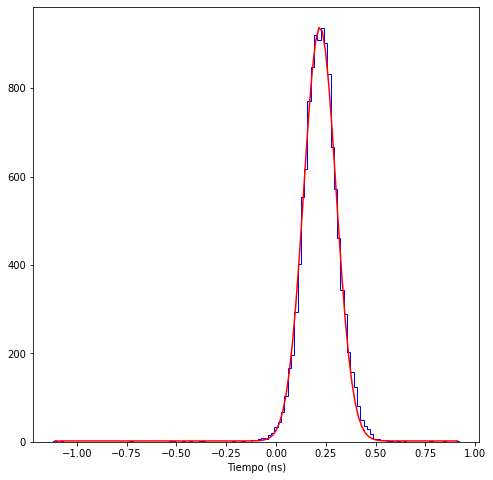

In [ ]:
plt.figure(figsize=(8,8))
nbins=3*41
histogN, binsN, patchesN  = plt.hist(TOFN,bins=nbins,color='white',edgecolor='blue',histtype=u'step');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])


#a_guess = 1 / (np.pi * max(histogN))
#x0_guess = sum(cbinsN * histogN) / sum(histogN)

def lorentz(x, *p):
    I, gamma, x0 = p
    return I * gamma**2 / ((x - x0)**2 + gamma**2)

# initial parameter guesses
 #[height, HWHM, shift]
#p1 = np.array([700, a_guess, x0_guess], dtype=np.double)   # single quantum


def fit(p, x, y):
    return curve_fit(lorentz, x, y, p0 = p)
  

 #Get the fitting parameters for the best lorentzian
#a, x0 = fit(p1, cbinsN, histogN)
#print(a)
#plt.plot(cbinsN,lorentz(cbinsN,*a),'r-')
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)
FWHMN = 2.35482 * sigmaN
plt.plot(cbinsN,gauss(cbinsN, HN, AN, x0N, sigmaN),'r-')
print("CENTROID= ",x0N)
print("SIGMA = ",sigmaN)
print("FWHM (ns)= ",FWHMN)

#plt.title('$^{22}$Na 5cm-5cm: predicted with model trained by 5cm-5cm data')
plt.xlabel('Tiempo (ns)')

## Every position

In [8]:
SUM1=np.sum(V1*0.2,axis=1)
print(np.mean(SUM1[:,0]),np.mean(SUM1[:,1]))

#Para el primer detector
histogE, binsE = np.histogram(SUM1[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m11=511/((binsE[index+1]+binsE[index])/2)
calibrado11=m11*SUM1[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM1[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m21=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m21*SUM1[:,0]

SUM2=np.sum(V2*0.2,axis=1)
print(np.mean(SUM2[:,0]),np.mean(SUM2[:,1]))

#Para el primer detector
histogE, binsE = np.histogram(SUM2[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m12=511/((binsE[index+1]+binsE[index])/2)
calibrado21=m12*SUM2[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM2[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m22=511/((binsE[index+1]+binsE[index])/2)
calibrado22=m22*SUM2[:,0]


SUM3=np.sum(V3*0.2,axis=1)
print(np.mean(SUM3[:,0]),np.mean(SUM3[:,1]))


#Para el primer detector
histogE, binsE = np.histogram(SUM3[:,0],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m13=511/((binsE[index+1]+binsE[index])/2)
calibrado31=m13*SUM3[:,0]


#Para el segundo detector
histogE, binsE = np.histogram(SUM3[:,1],bins=100);
histog_max=np.max(histogE)
index=np.where(histogE==histog_max)[0]
m23=511/((binsE[index+1]+binsE[index])/2)
#calibrado33=m23*SUM3[:,0]


V1 = V1[(m11*SUM1[:,0]>480) & (m11*SUM1[:,0]<540) & (m21*SUM1[:,1]>480) & (m21*SUM1[:,1]<540),:,:]
V2 = V2[(m12*SUM2[:,0]>480) & (m12*SUM2[:,0]<540) & (m22*SUM2[:,1]>480) & (m22*SUM2[:,1]<540),:,:]
V3 = V3[(m13*SUM3[:,0]>480) & (m13*SUM3[:,0]<540) & (m23*SUM3[:,1]>480) & (m23*SUM3[:,1]<540),:,:]


mean_0=np.mean([np.mean(V1[:,:,0]),np.mean(V2[:,:,0]),np.mean(V3[:,:,0])])
mean_1=np.mean([np.mean(V1[:,:,1]),np.mean(V2[:,:,1]),np.mean(V3[:,:,1])])
desv_est_0=np.mean([np.std(V1[:,:,0]),np.std(V2[:,:,0]),np.std(V3[:,:,0])])
desv_est_1=np.mean([np.std(V1[:,:,1]),np.std(V2[:,:,1]),np.std(V3[:,:,1])])

V1[:,:,0]=(V1[:,:,0]-mean_0)/desv_est_0
V1[:,:,1]=(V1[:,:,1]-mean_1)/desv_est_1
V2[:,:,0]=(V2[:,:,0]-mean_0)/desv_est_0
V2[:,:,1]=(V2[:,:,1]-mean_1)/desv_est_1
V3[:,:,0]=(V3[:,:,0]-mean_0)/desv_est_0
V3[:,:,1]=(V3[:,:,1]-mean_1)/desv_est_1


print(V1.shape,V2.shape,V3.shape)


4.8790483 3.2595406
4.8404737 3.5354571
4.4527645 3.5460122
(11411, 600, 2) (12648, 600, 2) (10571, 600, 2)


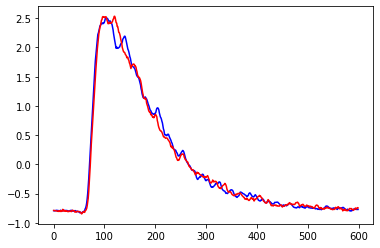

In [ ]:
plt.plot(V1[0,:,0],'b-')
plt.plot(V1[0,:,1],'r-')

In [9]:
VNN1 = V1[:,:,:]
VNN2 = V2[:,:,:]
VNN3 = V2[:,:,:]


Nev1 = [VNN1.shape[0],VNN2.shape[0],VNN3.shape[0]]
Ncasos = np.min(Nev1)  #Numero de eventos tras filtrar en energia AMBOS
remainder=(Ncasos % 128)
Ncasos=Ncasos-remainder
print(Ncasos,Ncasos/128)
Na_complete = np.concatenate((VNN1[0:Ncasos,60:124,:],VNN2[0:Ncasos,60:124,:],VNN3[0:Ncasos,60:124,:]), axis=0, out=None)

Npositions = 3
print(np.shape(Na_complete))
INPUT = Na_complete

11392 89.0
(34176, 64, 2)


In [10]:
INPUT2 = np.zeros_like(INPUT)
REF = np.zeros((Ncasos*Npositions,),dtype=np.float32)

tstep = 0.2
NRD0 = 1+np.random.randint(9, size=Ncasos*Npositions)  
NRD1 = 1+np.random.randint(9, size=Ncasos*Npositions)

offsets_position=[1.0029,0,-1.0029]
for j in range(Npositions):   
  offsetT = offsets_position[j]  
  for i in range(Ncasos*Npositions):
    N0 = NRD0[i] 
    INPUT2[i,:,0]=np.roll(INPUT[i,:,0],N0)
    INPUT2[i,0:N0,0] = INPUT[i,0:N0,0]
    N1 = NRD1[i]
    INPUT2[i,:,1]=np.roll(INPUT[i,:,1],N1)
    INPUT2[i,0:N1,1] = INPUT[i,0:N1,1]
    REF[i]=(N1-N0-offsetT)  #ns
    #REF[i]=N1-N0  #time steps


In [11]:
Ntrain = Ncasos-20*128
print(Ntrain/3) 

trainX_1 = INPUT2[0:Ntrain,:,:]
testX_1 = INPUT2[Ntrain:Ncasos,:,:]

trainX_2 = INPUT2[Ncasos:Ntrain+Ncasos,:,:]
testX_2 = INPUT2[Ntrain+Ncasos:2*Ncasos,:,:]

trainX_3 = INPUT2[2*Ncasos:2*Ncasos+Ntrain,:,:]
testX_3 = INPUT2[Ntrain+2*Ncasos:,:,:]

print(np.shape(trainX_1),np.shape(trainX_2),np.shape(trainX_3),np.shape(testX_3))

trainX = np.concatenate((trainX_1,trainX_2,trainX_3), axis=0, out=None)
testX = np.concatenate((testX_1,testX_2,testX_3), axis=0, out=None)

REF_train_1 = REF[0:Ntrain]
REF_test_1 = REF[Ntrain:Ncasos]

REF_train_2 = REF[Ncasos:Ntrain+Ncasos]
REF_test_2 = REF[Ntrain+Ncasos:2*Ncasos]

REF_train_3  = REF[2*Ncasos:2*Ncasos+Ntrain]
REF_test_3 = REF[Ntrain+2*Ncasos:]

REF_train = np.concatenate((REF_train_1,REF_train_2,REF_train_3), axis=0, out=None)
REF_test = np.concatenate((REF_test_1,REF_test_2,REF_test_3), axis=0, out=None)


print(testX.shape)

2944.0
(8832, 64, 2) (8832, 64, 2) (8832, 64, 2) (2560, 64, 2)
(7680, 64, 2)


In [12]:
# define two sets of inputs
# https://stackoverflow.com/questions/49875127/share-weights-between-two-dense-layers-in-keras
# https://stackoverflow.com/questions/66934276/how-to-create-a-model-with-multiple-shared-layers-in-keras-functional-api
offset_inicial = 0.0
inputA = Input(shape=(64,),)
inputB = Input(shape=(64,))
input_REF = Input(shape=(1,))

x1 = Dense(128, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.1))
x2 = Dense(64, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.1))
x3 = Dense(1, activation="relu")

#kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.5)

op1A = x1(inputA)
op2A = x2(op1A)
op3A = x3(op2A)

op1B = x1(inputB)
op2B = x2(op1B)
op3B = x3(op2B)

model_na_5_5 = Model(inputs=[inputA, inputB, input_REF], outputs=[op3A,op3B])

# OPTION 1 - USING LOSS FUNCTION IN THE MODEL
# https://stackoverflow.com/questions/51680818/keras-custom-loss-as-a-function-of-multiple-outputs
# Construct your custom loss as a tensor And Compile without specifying a loss
#loss = K.std(op3B-op3A-input_REF-offset_inicial) 
loss = 1*K.mean(abs(op3B-op3A-input_REF))+0*K.std(op3B-op3A-input_REF)
## Add loss to model
model_na_5_5.add_loss(loss)

model_na_5_5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]',              

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_na_5_5.compile(optimizer=opt) #, metrics=['accuracy']
history = model_na_5_5.fit(x=[trainX[:,:,0], trainX[:,:,1], REF_train],y=None,validation_data=([testX[:,:,0], testX[:,:,1],REF_test],[]),epochs=150, batch_size=128,shuffle=False)  

Epoch 1/150
207/207 [==============================] - 3s 3ms/step - loss: 2.7373 - val_loss: 2.5363
Epoch 2/150
207/207 [==============================] - 1s 3ms/step - loss: 2.3751 - val_loss: 2.2109
Epoch 3/150
207/207 [==============================] - 1s 3ms/step - loss: 2.0313 - val_loss: 1.8422
Epoch 4/150
207/207 [==============================] - 1s 3ms/step - loss: 1.7011 - val_loss: 1.5489
Epoch 5/150
207/207 [==============================] - 1s 3ms/step - loss: 1.4094 - val_loss: 1.2700
Epoch 6/150
207/207 [==============================] - 1s 3ms/step - loss: 1.1442 - val_loss: 1.0367
Epoch 7/150
207/207 [==============================] - 1s 3ms/step - loss: 0.9453 - val_loss: 0.8825
Epoch 8/150
207/207 [==============================] - 1s 3ms/step - loss: 0.8316 - val_loss: 0.8087
Epoch 9/150
207/207 [==============================] - 1s 3ms/step - loss: 0.7827 - val_loss: 0.7786
Epoch 10/150
207/207 [==============================] - 1s 3ms/step - loss: 0.7635 - val_lo

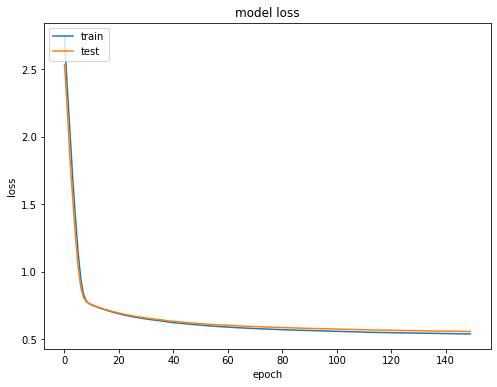

In [14]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
t0,t1 = model_na_5_5.predict([testX_1[:,:,0],testX_1[:,:,1],REF_test_1])
#t0,t1 = model_na_5_5.predict([trainX[:,:,0],trainX[:,:,1],REF_train])
print(t0.shape)
#print(o1[0:5],o2[0:5],REF_test[0:5])
#print(o2[0:5]-o1[0:5]-np.expand_dims(REF_test[0:5],-1))
TOFN = tstep*(t1-t0-np.expand_dims(REF_test_1,-1))
print(TOFN)
print ("STD =",np.std(TOFN))

80/80 [==============================] - 0s 4ms/step
(2560, 1)
[[-0.12039345]
 [ 0.03019106]
 [ 0.29404557]
 ...
 [ 0.10073765]
 [ 0.2826853 ]
 [ 0.22161904]]
STD = 0.12110368


CENTROID=  0.06708655818304866
SIGMA =  0.10747521082062655
FWHM (ns)=  0.25308477594462786


Text(0.5, 0, 'Tiempo (ns)')

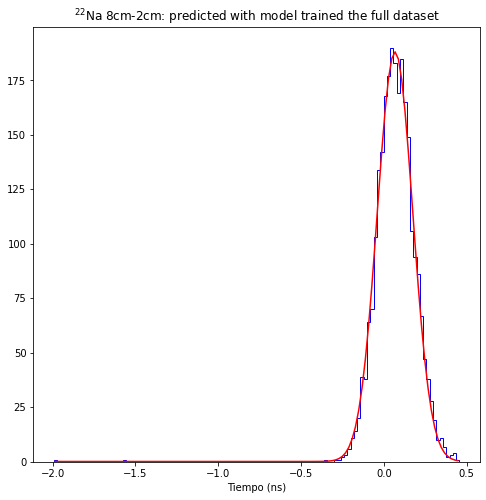

In [30]:
plt.figure(figsize=(8,8))
nbins=3*41
histogN, binsN, patchesN  = plt.hist(TOFN,bins=nbins,color='white',edgecolor='blue',histtype=u'step');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])


#a_guess = 1 / (np.pi * max(histogN))
#x0_guess = sum(cbinsN * histogN) / sum(histogN)

def lorentz(x, *p):
    I, gamma, x0 = p
    return I * gamma**2 / ((x - x0)**2 + gamma**2)

# initial parameter guesses
 #[height, HWHM, shift]
#p1 = np.array([700, a_guess, x0_guess], dtype=np.double)   # single quantum


def fit(p, x, y):
    return curve_fit(lorentz, x, y, p0 = p)
  

 #Get the fitting parameters for the best lorentzian
#a, x0 = fit(p1, cbinsN, histogN)
#print(a)
#plt.plot(cbinsN,lorentz(cbinsN,*a),'r-')
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)
FWHMN = 2.35482 * sigmaN
plt.plot(cbinsN,gauss(cbinsN, HN, AN, x0N, sigmaN),'r-')
print("CENTROID= ",x0N)
print("SIGMA = ",sigmaN)
print("FWHM (ns)= ",FWHMN)

plt.title('$^{22}$Na 8cm-2cm: predicted with model trained the full dataset')
plt.xlabel('Tiempo (ns)')
